<a href="https://colab.research.google.com/github/zajacn/MetaVizAtlas_Tutorial_Part2/blob/main/MetaVizAtlas_Tutorial_Part2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metagenome Atlas tutorial

Once you have analysed your data with Metagenome Atlas you would like to visualise it, better understand the taxonomic composition and the functions of the genomes found across your samples. Here we will go in detail and answer questions from the quiz linked in the github.

In [1]:
! git clone https://github.com/zajacn/MetaVizAtlas_Tutorial_Part2.git materials
! cd materials

Cloning into 'materials'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 247 (delta 8), reused 7 (delta 2), pack-reused 226 (from 1)
Receiving objects: 100% (247/247), 104.44 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (190/190), done.


**PLEASE ENTER YOUR EMAIL AND PASSWORD TO BFABRIC BELOW** You can immediately delete it afterwards, this is not saved anywhere.

In [2]:
! wget -O library.metaatlas.tar.gz https://fgcz-gstore.uzh.ch/projects/p35545/library.metaatlas.tar.gz --user= --password=

--2024-12-03 13:15:09--  https://fgcz-gstore.uzh.ch/projects/p35545/library.metaatlas.tar.gz
Resolving fgcz-gstore.uzh.ch (fgcz-gstore.uzh.ch)... 130.60.193.36
Connecting to fgcz-gstore.uzh.ch (fgcz-gstore.uzh.ch)|130.60.193.36|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="FGCZ B-Fabric LDAP"
Reusing existing connection to fgcz-gstore.uzh.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: 559341056 (533M) [application/x-gzip]
Saving to: ‘library.metaatlas.tar.gz’

library.metaatlas.t 100%[===================>] 533.43M  15.7MB/s    in 34s     

2024-12-03 13:15:45 (15.6 MB/s) - ‘library.metaatlas.tar.gz’ saved [559341056/559341056]



In [3]:
!tar xf library.metaatlas.tar.gz

tar: Removing leading `/' from member names


In [4]:
# activate R magic
%load_ext rpy2.ipython

In [5]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [6]:
%%R
library(heatmaply)
library(dplyr) # dpyr masks select from plotly
library(readr)
library(stringr)
library(tidyr)
library(tibble)
library(ggplot2)
library(ggbeeswarm)
library(pheatmap)
library(grid)
library(microbiome)
library(ape)
library(vegan)
library(useful)
library(kableExtra)
library(ggtree)
library(arrow)
library(yaml)
library(phyloseq)
library(microViz)



Attaching package: ‘plotly’



    last_plot



    filter



    layout




Welcome to heatmaply version 1.5.0

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
You may ask questions at stackoverflow, use the r and heatmaply tags: 
	 https://stackoverflow.com/questions/tagged/heatmaply


Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union



  method         from      
  reorder.hclust seriation 
  rev.hclust     dendextend

microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>


Attaching package: ‘microbiome’



    alpha



    transform


Attaching package: ‘ape’



    where





Attaching package: ‘vegan’



    diversity


 there is no package called


Error: package or namespace load failed for ‘kableExtra’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘svglite’


In [7]:
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

In [8]:
%%R
atlas_wd_folder <- "materials/dataset/"

taxonomy_file <- paste0(atlas_wd_folder, "genomes/taxonomy/gtdb_taxonomy.tsv")
tree_file <- paste0(atlas_wd_folder, "genomes/tree/gtdbtk.bac120.nwk")
quality_file <- paste0(atlas_wd_folder, "genomes/checkm/completeness.tsv")
counts_file <- paste0(atlas_wd_folder, "genomes/counts/raw_counts_genomes.tsv")
abundance_file <- paste0(atlas_wd_folder, "genomes/counts/median_coverage_genomes.tsv")
readstats_file <- paste0(atlas_wd_folder, "stats/read_counts.tsv")
keggmodules_file <- paste0(atlas_wd_folder, "genomes/annotations/dram/kegg_modules.tsv")

In [9]:
%%R
metadata <- read.table(file.path(atlas_wd_folder, "metadata.txt"), sep = "\t", header = TRUE, row.names = "X")
metadata <- metadata[c("Diet", "Body_weight")]
head(metadata)
group_variable <- "Diet"

We confirm that the mice on high-fat diet really put more weight on.

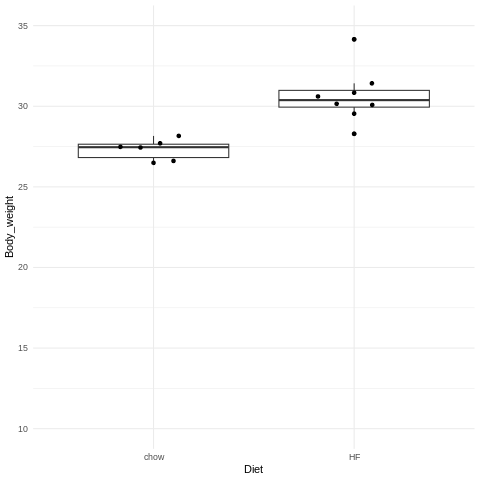

In [10]:
%%R
ggplot(metadata, aes(x = Diet, y = Body_weight)) +
  geom_boxplot() +
  geom_beeswarm(cex = 5) +
  ylim(10, 35) +
  theme_minimal()

# Load Atlas output

## Taxonomy

In [11]:
%%R
Tax <- read_tsv(taxonomy_file, show_col_types = FALSE)
Tax

# A tibble: 33 × 8
   user_genome Domain   phylum           class        order family genus species
   <chr>       <chr>    <chr>            <chr>        <chr> <chr>  <chr> <chr>  
 1 MAG01       Bacteria Bacteroidota     Bacteroidia  Bact… Bacte… Phoc… Phocae…
 2 MAG02       Bacteria Firmicutes_A     Clostridia   Lach… Lachn… Anae… <NA>   
 3 MAG03       Bacteria Actinobacteriota Coriobacter… Cori… Atopo… NM07… NM07-P…
 4 MAG04       Bacteria Bacteroidota     Bacteroidia  Bact… Murib… Para… Paramu…
 5 MAG05       Bacteria Firmicutes_A     Clostridia   Lach… Lachn… Acet… Acetat…
 6 MAG06       Bacteria Firmicutes       Bacilli      Lact… Lacto… Limo… Limosi…
 7 MAG07       Bacteria Bacteroidota     Bacteroidia  Bact… Bacte… Phoc… Phocae…
 8 MAG08       Bacteria Firmicutes       Bacilli      Lact… Lacto… Lact… Lactob…
 9 MAG09       Bacteria Bacteroidota     Bacteroidia  Bact… Bacte… Bact… Bacter…
10 MAG10       Bacteria Bacteroidota     Bacteroidia  Bact… Murib… CAG-… <NA>   
# ℹ 23 mo

In [12]:
%%R
# create a short label for each species
Tax <- Tax %>%
  mutate(Label = ifelse(is.na(species) & is.na(genus), paste0(family, " ", user_genome), species)) %>%
  mutate(Label = ifelse(is.na(Label), paste0(genus, " ", user_genome), Label)) %>%
  mutate(species = Label, Label = NULL)

## Draw tree

In [13]:
%%R
Tree <- ggtree::read.tree(tree_file)
Tree <- full_join(Tree, dplyr::rename(Tax, label = user_genome), by = "label")

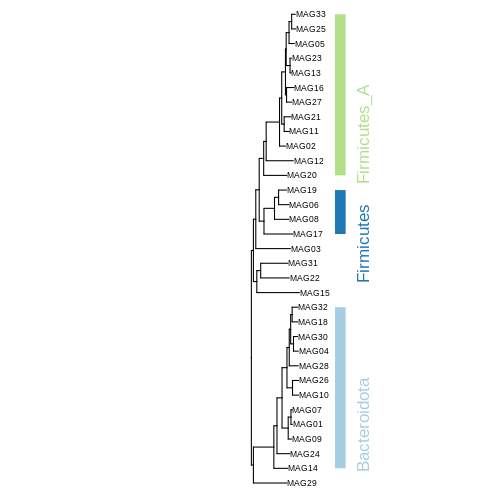

In [16]:
%%R -h 500 -w 500
library(phytools)
library(ggtree)
tree_plot <- ggtree(Tree) + geom_tiplab(size =3)




phylum_counts <- table(Tax$phylum)
phylum_to_label <- names(phylum_counts)[phylum_counts > 1]

phylum_colors <- RColorBrewer::brewer.pal(length(phylum_to_label), "Paired")
names(phylum_colors) <- phylum_to_label



for (phy in phylum_to_label) {
  phy_tax <- Tax %>% filter(phylum == phy)

  phy_mrca <- findMRCA(Tree@phylo, phy_tax$user_genome)


  tree_plot <- tree_plot +
    geom_cladelabel(
      node = phy_mrca,
      label = phy,
      fontsize = 6,
      fill = phylum_colors[phy],
      color = phylum_colors[phy],
      align = TRUE,
      offset = 0.9,
      offset.text = 0.5,
      barsize = 5,
      angle = 90,
      hjust = 0.9,
    )
}



tree_plot + xlim(-5, 5)

This plot is not the best and not very clear. To answer the questions regarding the plot, go to materials -> dataset -> genomes -> taxonomy and download the file gtdb_taxonomy.tsv.

# Genome quality

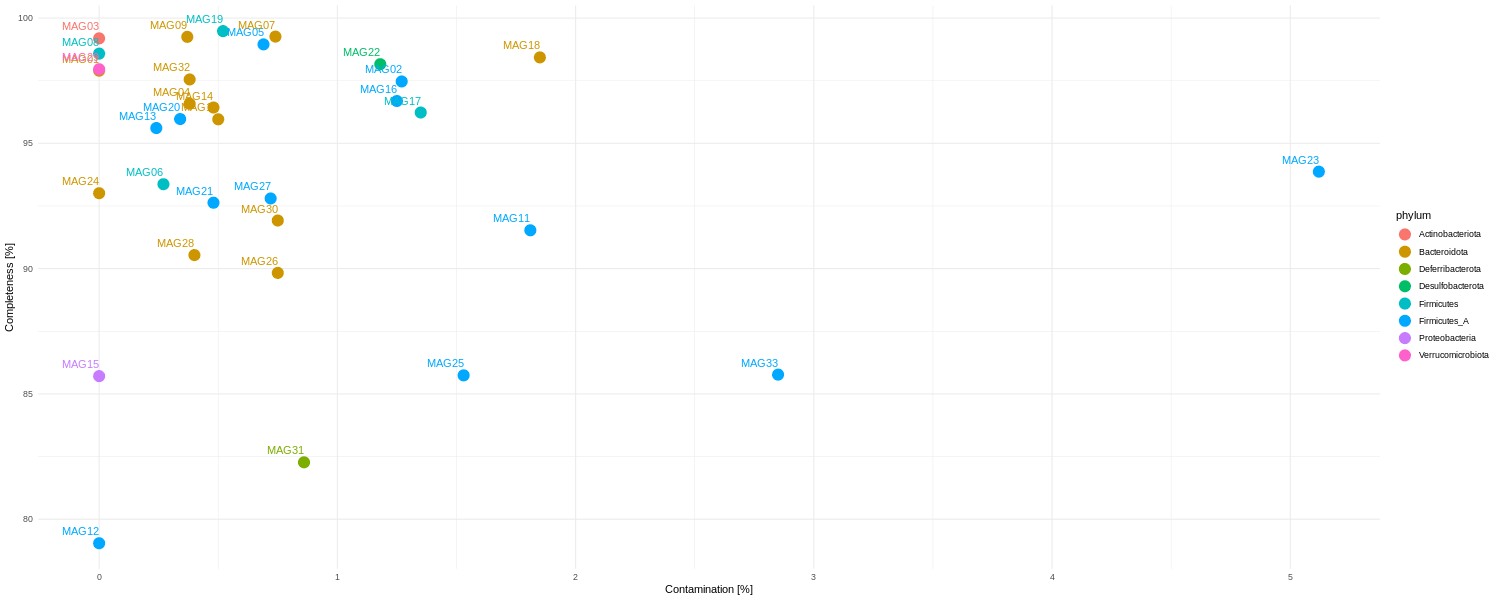

In [17]:
%%R -w 1500 -h 600 -u px
genome_quality <- read_tsv(quality_file, show_col_types = FALSE) %>%
  mutate(Quality_Score = Completeness - (5 * Contamination)) %>%
  left_join(Tax, by = c("Bin Id" = "user_genome")) %>%
  mutate(Name = species) %>%
  dplyr::select(-species)

plt <- ggplot(genome_quality, aes(
  x = Contamination, y = Completeness, color = phylum, label = `Bin Id`,
  text = paste("Bin Id:", `Bin Id`, "\nName", Name, "\nQuality score:", Quality_Score)
)) +
  geom_point(size = 5) + geom_text(hjust=1, vjust=-1) +
  xlab("Contamination [%]") +
  ylab("Completeness [%]") +
  theme_minimal()

plt

## Relative abundance

For the relative abundance, we take the coverage over the genome, not the raw counts.
This implicitly normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.


In [18]:
%%R
D <- read_tsv(abundance_file, show_col_types = FALSE) %>%
  column_to_rownames("...1") %>%
  as.matrix()


# calculate relative abundance
rel_ab <- sweep(D, 1, rowSums(D), `/`)

# get most abundant genomes
counts_per_genome <- data.frame(sums = colSums(rel_ab)) %>%
  rownames_to_column(var = "Genome") %>%
  left_join(Tax, by = c("Genome" = "user_genome")) %>%
  arrange(desc(sums))

print(D)


New names:
• `` -> `...1`
          MAG01  MAG02 MAG03  MAG04 MAG05  MAG06 MAG07 MAG08  MAG09  MAG10
ERR675519  4.94 20.065 34.74  0.000 46.82 30.685 44.56 41.87  0.440   0.00
ERR675520 30.67  0.270  0.00 56.440  0.00  0.000  0.20  0.00 79.195  73.07
ERR675521 14.30 22.310  0.00  8.630 40.05 35.425  0.00 26.23  0.870   1.12
ERR675522 28.06  0.270 32.56  0.080  0.28  0.000  0.00  0.00 44.530 151.44
ERR675523 23.03  3.920  1.67 22.200  3.28  0.090  0.00 46.57  5.300   1.62
ERR675524 17.50  0.340 36.75 51.015  0.76  0.000  0.00  0.34 57.400 224.66
ERR675525 26.59  2.270  0.00 26.170 23.90  0.010  0.00  2.40  2.520   1.89
ERR675526 38.19  0.450 17.24 79.580  2.39  0.000  0.00  0.00 92.590  93.33
ERR675527 50.19  0.170  6.08 47.225  0.09  0.000  0.00  0.00 35.500  40.53
ERR675528 15.97 10.930  0.00  2.925 37.11 15.355  0.00 25.13  1.200   0.00
ERR675529 32.15  0.390  0.00 42.200  0.51  0.000  0.00  0.00 41.570  60.82
ERR675530  0.72  1.990 39.35  0.000 29.30 12.210 35.40 32.47  0.160   0.00

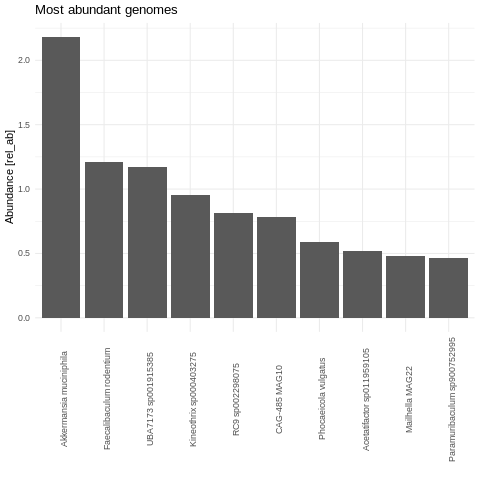

In [19]:
%%R
ggplot(counts_per_genome %>%
  top_n(sums, n = 10), aes(x = reorder(species, -sums), y = sums)) +
  geom_col() +
  labs(x = "", y = "Abundance [rel_ab]", title = "Most abundant genomes") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90))

### Phyloseq

Let's create a phyloseq object for further analysis.

In [22]:
%%R
nw_tree <- ape::read.tree(tree_file)

# if you have real metadate the better

if (!exists("metadata")) {
  metadata <- data.frame(row.names = rownames(rel_ab))
  metadata$group <- "NoGroup"
}


pseq <- phyloseq(
  otu_table(rel_ab, taxa_are_rows = FALSE),
  tax_table(as.matrix(column_to_rownames(Tax, "user_genome"))),
  phy_tree(nw_tree),
  sample_data(metadata)
)

# fix taxonomy
pseq <- pseq %>%
  microViz::tax_fix()

microViz::phyloseq_validate(pseq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 33 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 33 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 33 tips and 32 internal nodes ]


### Ordination analysis

Here we use the recommended robust Centered log ratio transformation with PCA.
This corresponds to a PCoA with Aitchison distances.



microViz version 0.11.0 - Copyright (C) 2023 David Barnett
! Website: <https://david-barnett.github.io/microViz>
✔ Useful?  For citation details, run: `citation("microViz")`
✖ Silence? `suppressPackageStartupMessages(library(microViz))`


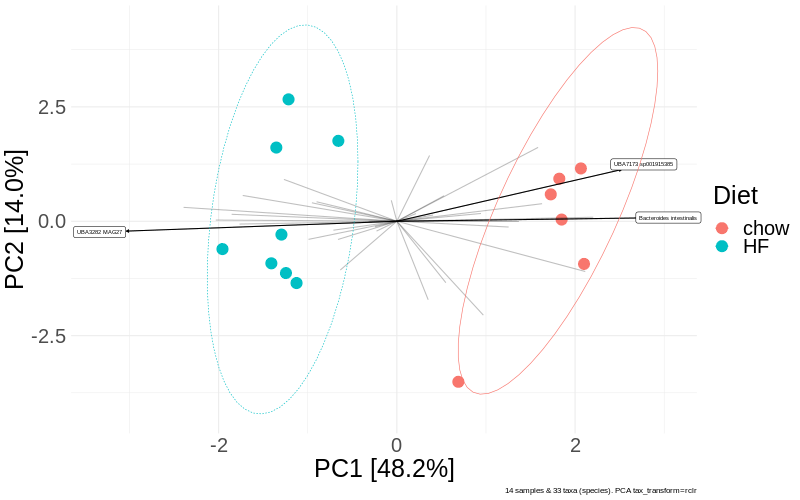

In [26]:
%%R -w 800 -h 500 -u px
library(microViz)
ordination <- pseq %>%
  tax_transform(rank = "species", trans = "rclr") %>%
  ord_calc(
    method = "auto"
  )


ordination %>%
  ord_plot(
    plot_taxa = 1:3,
    colour = "Diet", fill = "Diet",
    size = 5, fontsize = 15
  ) +
  stat_ellipse(aes(linetype = Diet, colour = Diet), linewidth = 0.3) + theme(text = element_text(size = 25))

### Typical bar chart

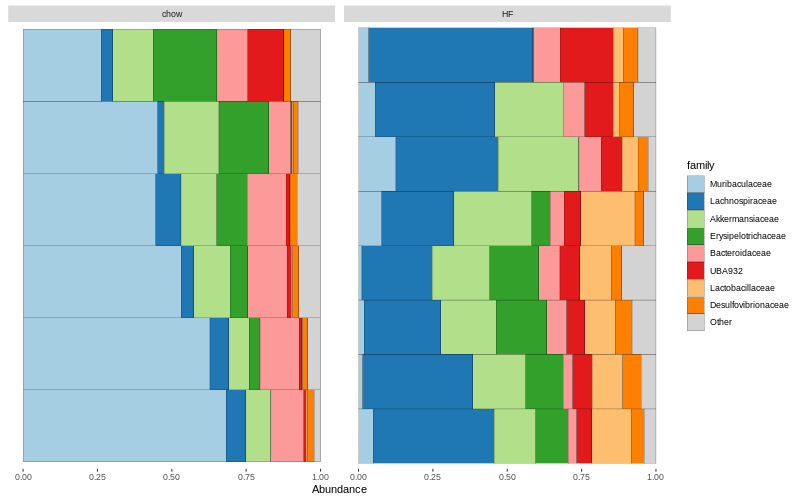

In [27]:
%%R -w 800 -h 500 -u px
pseq %>% comp_barplot(tax_level = "family", facet_by = "Diet") +
  coord_flip() +
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

Heatmap

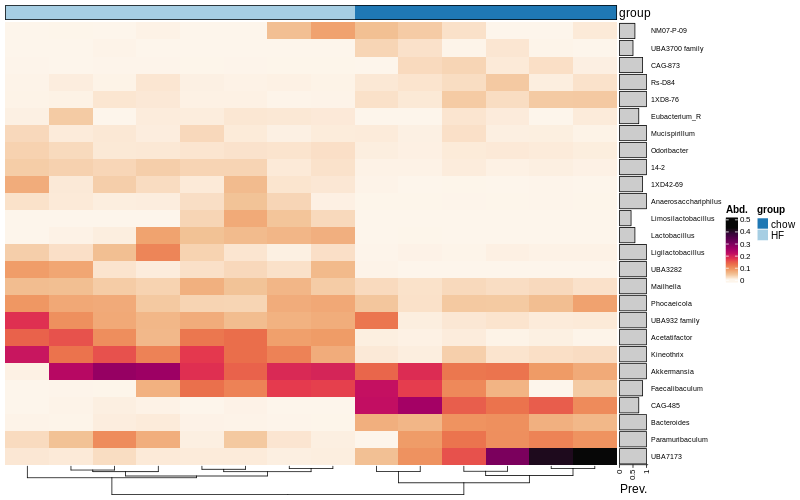

In [28]:
%%R -w 800 -h 500 -u px
cols <- distinct_palette(n = 2, add = NA)
names(cols) <- unique(samdat_tbl(pseq)$Diet)




htmp <- pseq %>%
  tax_transform("compositional", rank = "genus") %>%
  tax_filter(min_prevalence = 0.25, prev_detection_threshold = 0.001, use_counts = FALSE) %>%
  comp_heatmap(
    grid_col = NA,
    cluster_rows = FALSE, row_title = NULL,
    # row_split = 5, #seq_len(ntaxa(ps_get(pseq))),
    tax_anno = taxAnnotation(
      Prev. = anno_tax_prev(bar_width = 0.9, size = grid::unit(1, "cm"), border = F)
    ),
    sample_anno = sampleAnnotation(
      # method one
      group = anno_sample("Diet"),
      col = list(group = cols), border = TRUE
    )
  )
htmp %>% ComplexHeatmap::draw(
  annotation_legend_list = attr(htmp, "AnnoLegends")
)

# Functional annotations of genomes

The relative abundance of functional annotations per sample

The abundance is calculated as the sum of the relative abundance of all bacteria containing a function.

## Kegg modules produced by Dram

In [29]:
%%R
kegg_modules <- read_tsv(keggmodules_file, col_select = -1)
module_names <- kegg_modules %>%
  dplyr::select(c("module", "module_name")) %>%
  distinct() %>%
  column_to_rownames("module")


print(head(kegg_modules))

New names:
• `` -> `...1`
Rows: 13167 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): genome, module, module_name, kos_present, genes_present
dbl (4): steps, steps_present, step_coverage, ko_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 × 9
  genome module module_name           steps steps_present step_coverage ko_count
  <chr>  <chr>  <chr>                 <dbl>         <dbl>         <dbl>    <dbl>
1 MAG14  M00001 Glycolysis (Embden-M…     9             9         1           10
2 MAG14  M00002 Glycolysis, core mod…     5             5         1            6
3 MAG14  M00003 Gluconeogenesis, oxa…     7             7         1            7
4 MAG14  M00004 Pentose phosphate pa…     7             4         0.571        4
5 MAG14  M00005 PRPP biosynthesis, r…     1             1         1        

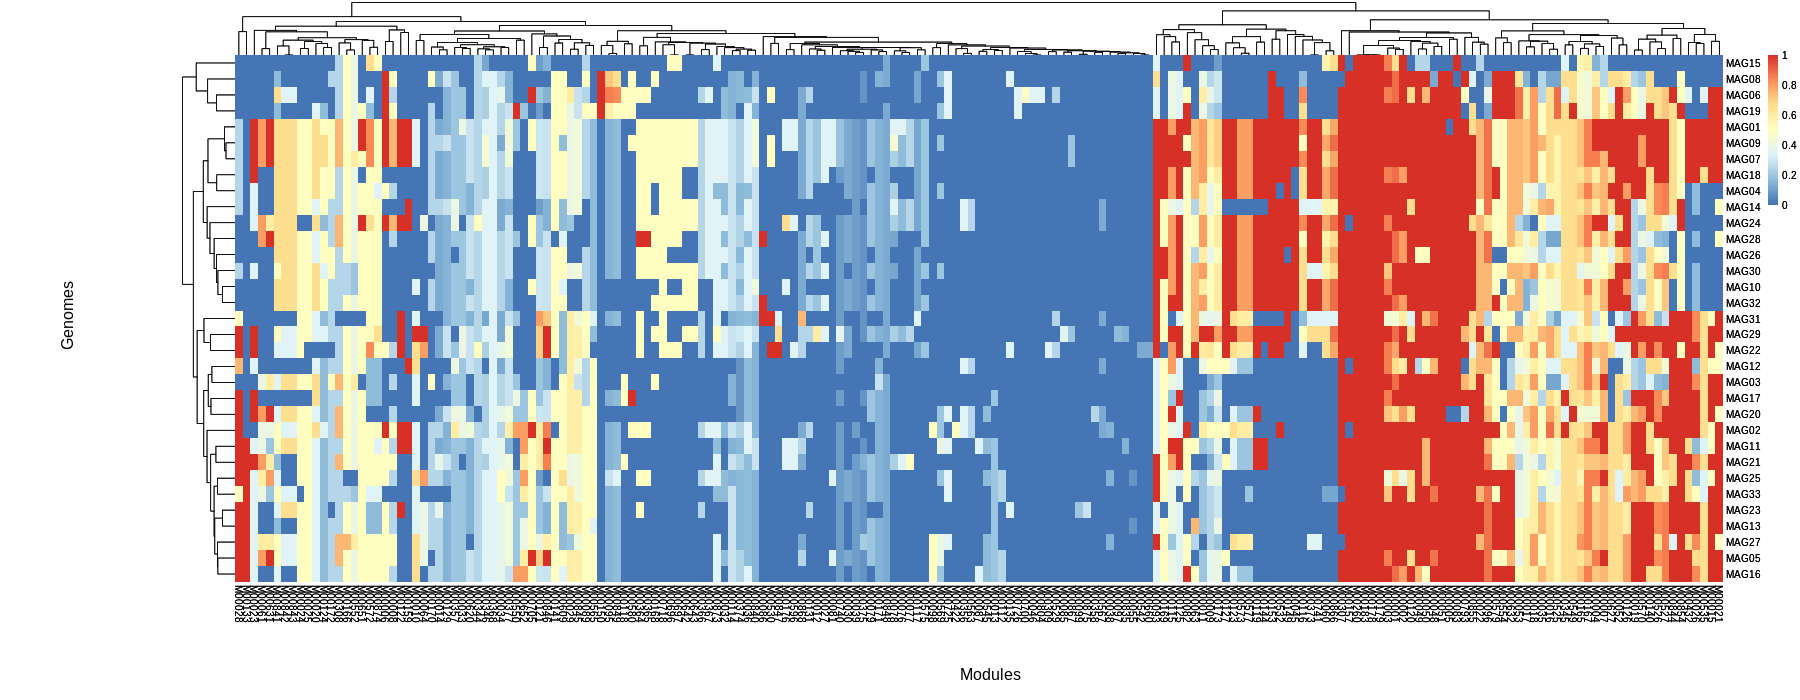

In [30]:
%%R -w 1800 -h 700 -u px
step_coverage_threshold <- 0.8

module_step_coverage_matrix <- pivot_wider(kegg_modules,
  id_cols = genome,
  names_from = module,
  values_from = step_coverage
) %>%
  column_to_rownames("genome") %>%
  as.matrix()

module_step_coverage_matrix <- module_step_coverage_matrix[, colSums(module_step_coverage_matrix) > 0]

setHook("grid.newpage", function() pushViewport(viewport(x = 1, y = 1, width = 0.9, height = 0.9, name = "vp", just = c("right", "top"))), action = "prepend")
hatmap <- pheatmap(module_step_coverage_matrix, show_colnames = T, show_rownames = T)
setHook("grid.newpage", NULL, "replace")
grid.text("Modules", y = -0.07, gp = gpar(fontsize = 16))
grid.text("Genomes", x = -0.07, rot = 90, gp = gpar(fontsize = 16))



module_presence_matrix <- 1 * (module_step_coverage_matrix > step_coverage_threshold)

module_presence_matrix <- module_presence_matrix[, colSums(module_presence_matrix) > 0]

hatmap

In [36]:
%%R -w 1800 -h 700 -u px
d_tax <- column_to_rownames(Tax, "user_genome")



annotations <- matrix("", nrow = nrow(module_step_coverage_matrix), ncol = ncol(module_step_coverage_matrix))
colnames(annotations) <- colnames(module_step_coverage_matrix)
rownames(annotations) <- rownames(module_step_coverage_matrix)

for (genome in rownames(annotations))
{
  for (module in colnames(annotations))
  {
    annotations[genome, module] <- paste0(
      "Name: ", d_tax[genome, "species"],
      "\nPhylum: ", d_tax[genome, "phylum"],
      "\nPathway: ", module_names[module, "name"]
    )
  }
}




heatmaply(module_step_coverage_matrix,
  custom_hovertext = annotations,
  row_side_colors = list(Phylum = d_tax[rownames(module_step_coverage_matrix), "phylum"]),
  showticklabels = c(FALSE, FALSE)
)

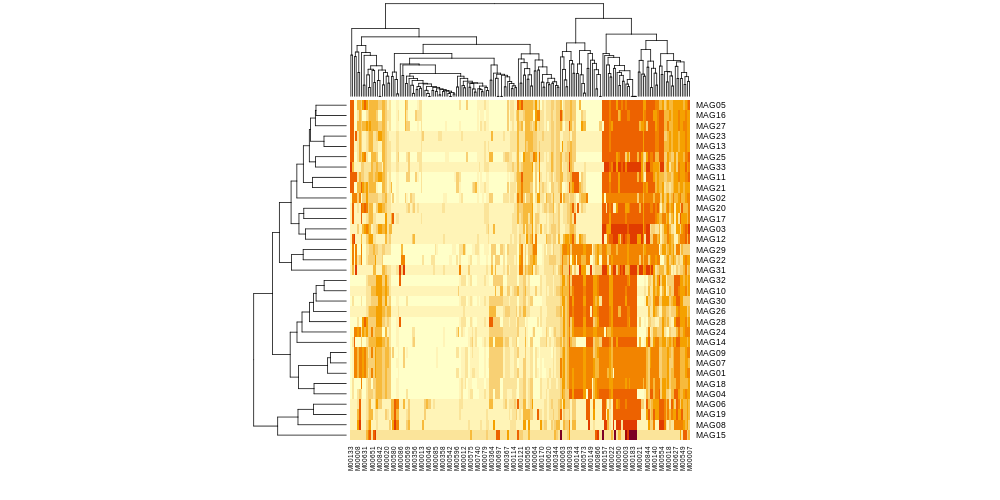

In [32]:
%%R -w 1000 -h 500 -u px
heatmap(module_step_coverage_matrix)

### Module abundance

Calculate Abundance of pathways as the sum of abundance of species where a module is presence. This is equal to the matrix multiplication.


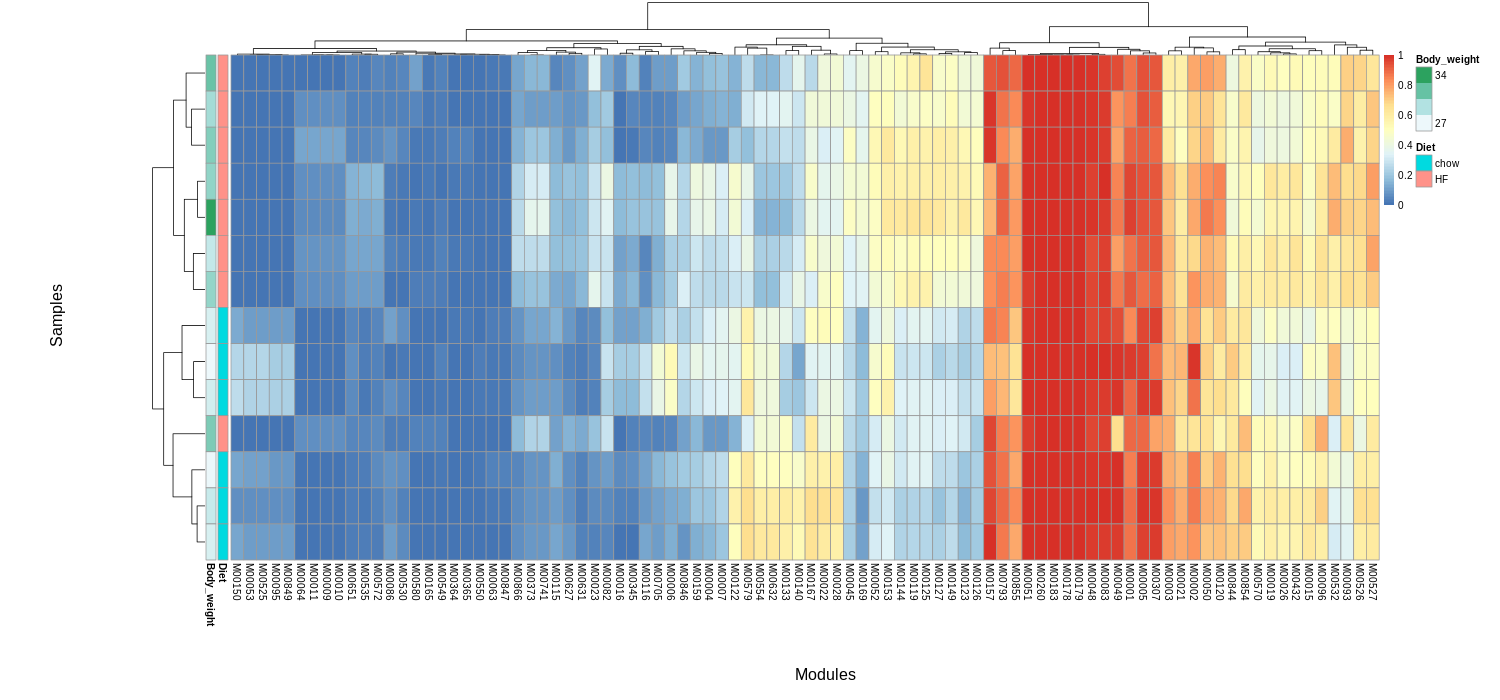

In [37]:
%%R -h 700 -w 1500 -u px
stopifnot(dim(rel_ab)[2] == dim(module_presence_matrix)[1])
module_rel_ab <- as.matrix(rel_ab) %*% module_presence_matrix


setHook("grid.newpage", function() pushViewport(viewport(x = 1, y = 1, width = 0.9, height = 0.9, name = "vp", just = c("right", "top"))), action = "prepend")
pheatmap(module_rel_ab, show_rownames = F, show_colnames = T, annotation_row = metadata)

setHook("grid.newpage", NULL, "replace")
grid.text("Modules", y = -0.07, gp = gpar(fontsize = 16))
grid.text("Samples", x = -0.07, rot = 90, gp = gpar(fontsize = 16))

In [39]:
%%R
annotations <- matrix("", nrow = nrow(module_rel_ab), ncol = ncol(module_rel_ab))
colnames(annotations) <- colnames(module_rel_ab)
rownames(annotations) <- rownames(module_rel_ab)
for (sample in rownames(annotations))
{
  for (module in colnames(annotations))
  {
    annotations[sample, module] <- paste0(
      "Pathway: ", module_names[module, ]
    )
  }
}




heatmaply(module_rel_ab,
  custom_hovertext = annotations,
  showticklabels = c(FALSE, FALSE),
  row_side_colors = list(Diet = metadata[rownames(module_rel_ab), "Diet"]),
  colors = "RdBu"
)

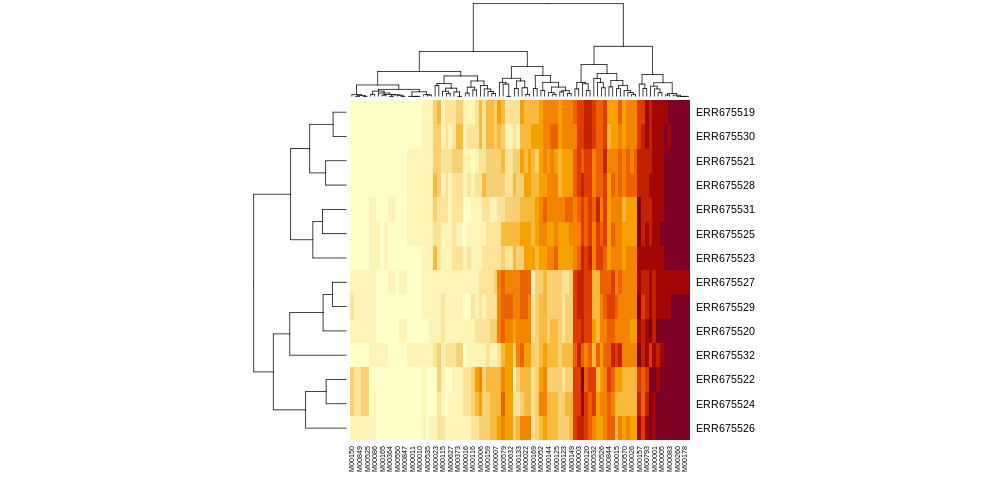

In [40]:
%%R -w 1000 -h 500 -u px
heatmap(module_rel_ab)

## Average abundance across samples of different modules

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


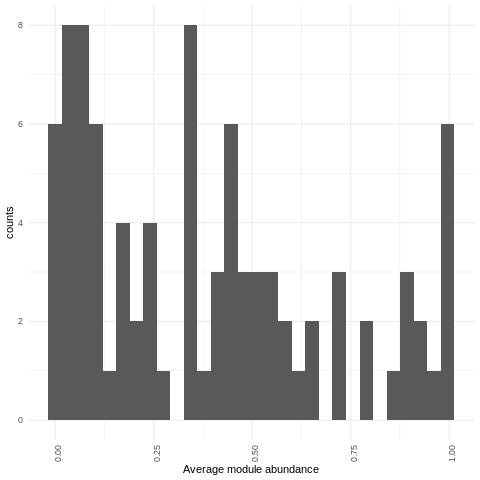

In [41]:
%%R
abundance_per_module <- data.frame(abundance = colMeans(module_rel_ab)) %>% arrange(desc(abundance))
abundance_per_module <- cbind(abundance_per_module, module_names[rownames(abundance_per_module), ])
colnames(abundance_per_module) <- c("Average_abundance", "Description")






ggplot(abundance_per_module, aes(x = Average_abundance)) +
  geom_histogram() +
  labs(x = "Average module abundance", y = "counts") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90))

In [42]:
%%R
abundance_per_module[abundance_per_module$Average_abundance >= 0.975,]

       Average_abundance
M00178         1.0000000
M00179         1.0000000
M00183         1.0000000
M00260         1.0000000
M00051         0.9900069
M00083         0.9789119
                                                         Description
M00178                                            Ribosome, bacteria
M00179                                             Ribosome, archaea
M00183                                      RNA polymerase, bacteria
M00260                          DNA polymerase III complex, bacteria
M00051 Uridine monophosphate biosynthesis, glutamine (+ PRPP) => UMP
M00083                           Fatty acid biosynthesis, elongation
